### Import necessary libraries

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import ast
import prince

from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows', None)

### Data loading

In [405]:
data = pd.read_excel("data/set_complet_curatat_tradus.xlsx")

In [406]:
data['phenomena'] = data['phenomena'].apply(ast.literal_eval)

In [409]:
# Drop the specified columns and keep the specified ones
selected_columns = ['date', 'region', 'phenomena', 'county',
                    'pm10_quality', 
                    'air_pressure', 
                    'temperature', 
                    'humidity']

data_selected_cleaned = data[selected_columns]

# Drop rows with missing values
# data_selected_cleaned = data_selected.dropna()

### Elbow Method to determine the number of clusters

In [410]:
data_exploded = data_selected_cleaned.copy()
data_exploded = data_exploded.explode('phenomena')

1
2
3
4
5
6
7
8
9
10


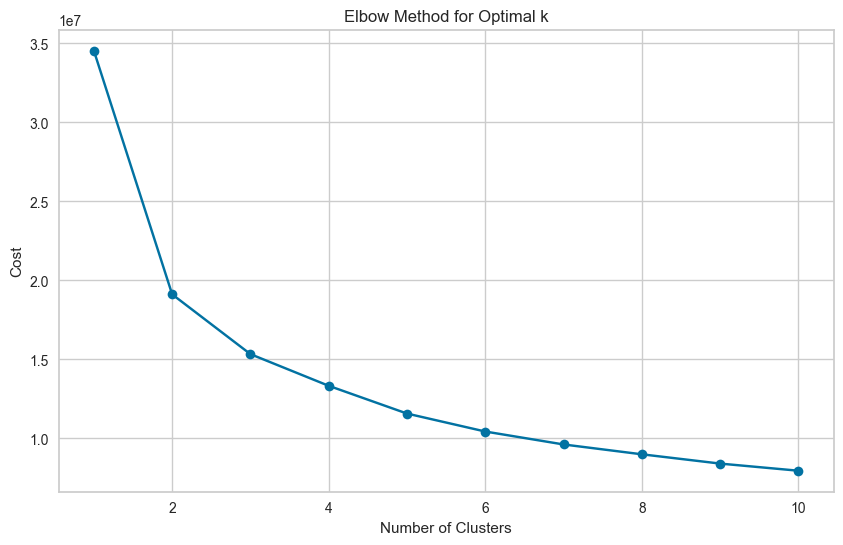

In [212]:
sample_data = data_exploded.sample(frac=0.5, random_state=42).drop(columns=['date', 'county', 'region'])

costs = []
K = range(1, 11)

for k in K:
    print(k)
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, n_jobs=-1)
    kproto.fit_predict(sample_data, categorical=[0])
    costs.append(kproto.cost_)

plt.figure(figsize=(10, 6))
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [411]:
optimal_clusters = 4 
kproto = KPrototypes(n_clusters=optimal_clusters, init='Cao', verbose=0, n_jobs=-1)
clusters = kproto.fit_predict(data_exploded.drop(columns=['date','county', 'region']), categorical=[0])

In [412]:
data_exploded['Cluster'] = clusters

#### Value counts of every cluster

In [413]:
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
cluster_sizes

0    17377
1     3522
2    11464
3    18589
Name: count, dtype: int64

### Central Tendency


In [414]:
# data_selected_cleaned['Cluster'] = clusters

# Central Tendency
numerical_cols = ['pm10_quality', 'air_pressure', 
                  'temperature', 'humidity']
categorical_cols = ['region', 'phenomena', 'county']

# Mean for numerical attributes
cluster_means = data_exploded.groupby('Cluster')[numerical_cols].mean()

# Mode for categorical attributes
cluster_modes = data_exploded.groupby('Cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

central_tendency = pd.concat([cluster_means, cluster_modes], axis=1)

central_tendency

,pm10_quality,air_pressure,temperature,humidity,region,phenomena,county
Cluster,,,,,,,
0,25.877299,1000.398080,19.407341,60.343610,Muntenia,Rain,B
1,58.959509,1000.766356,5.152165,79.490036,Moldova,Rain,IS
2,22.836281,946.322733,11.497582,77.498447,Transilvania,Snow,BV
3,21.277777,1006.512984,10.238409,85.601902,Dobrogea,Rain,CT


#### Standard deviation within each cluster

In [415]:
# Standard deviation for numerical attributes
cluster_std_dev = data_exploded.groupby('Cluster')[numerical_cols].std()
cluster_std_dev

,pm10_quality,air_pressure,temperature,humidity
Cluster,,,,
0,9.096693,11.756491,7.340540,10.411136
1,20.889484,15.730278,9.205320,11.862628
2,11.525236,17.011504,8.742236,12.034943
3,7.928257,14.986998,8.504607,8.251550


### Study the top 10 phenomena among each cluster

In [416]:
def get_season(date):
    """Return the season for a given date."""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# data_selected_cleaned['Cluster'] = clusters

# Extracting the season
data_exploded['Season'] = data_exploded['date'].apply(get_season)

In [417]:
# Recreate the phenomena_counts variable without further manipulation of 'phenomena'
# phenomena_exploded = data_selected_cleaned.explode('phenomena')
phenomena_counts = data_exploded.groupby(['Season', 'Cluster'])['phenomena'].value_counts().unstack(level=-1).fillna(0)

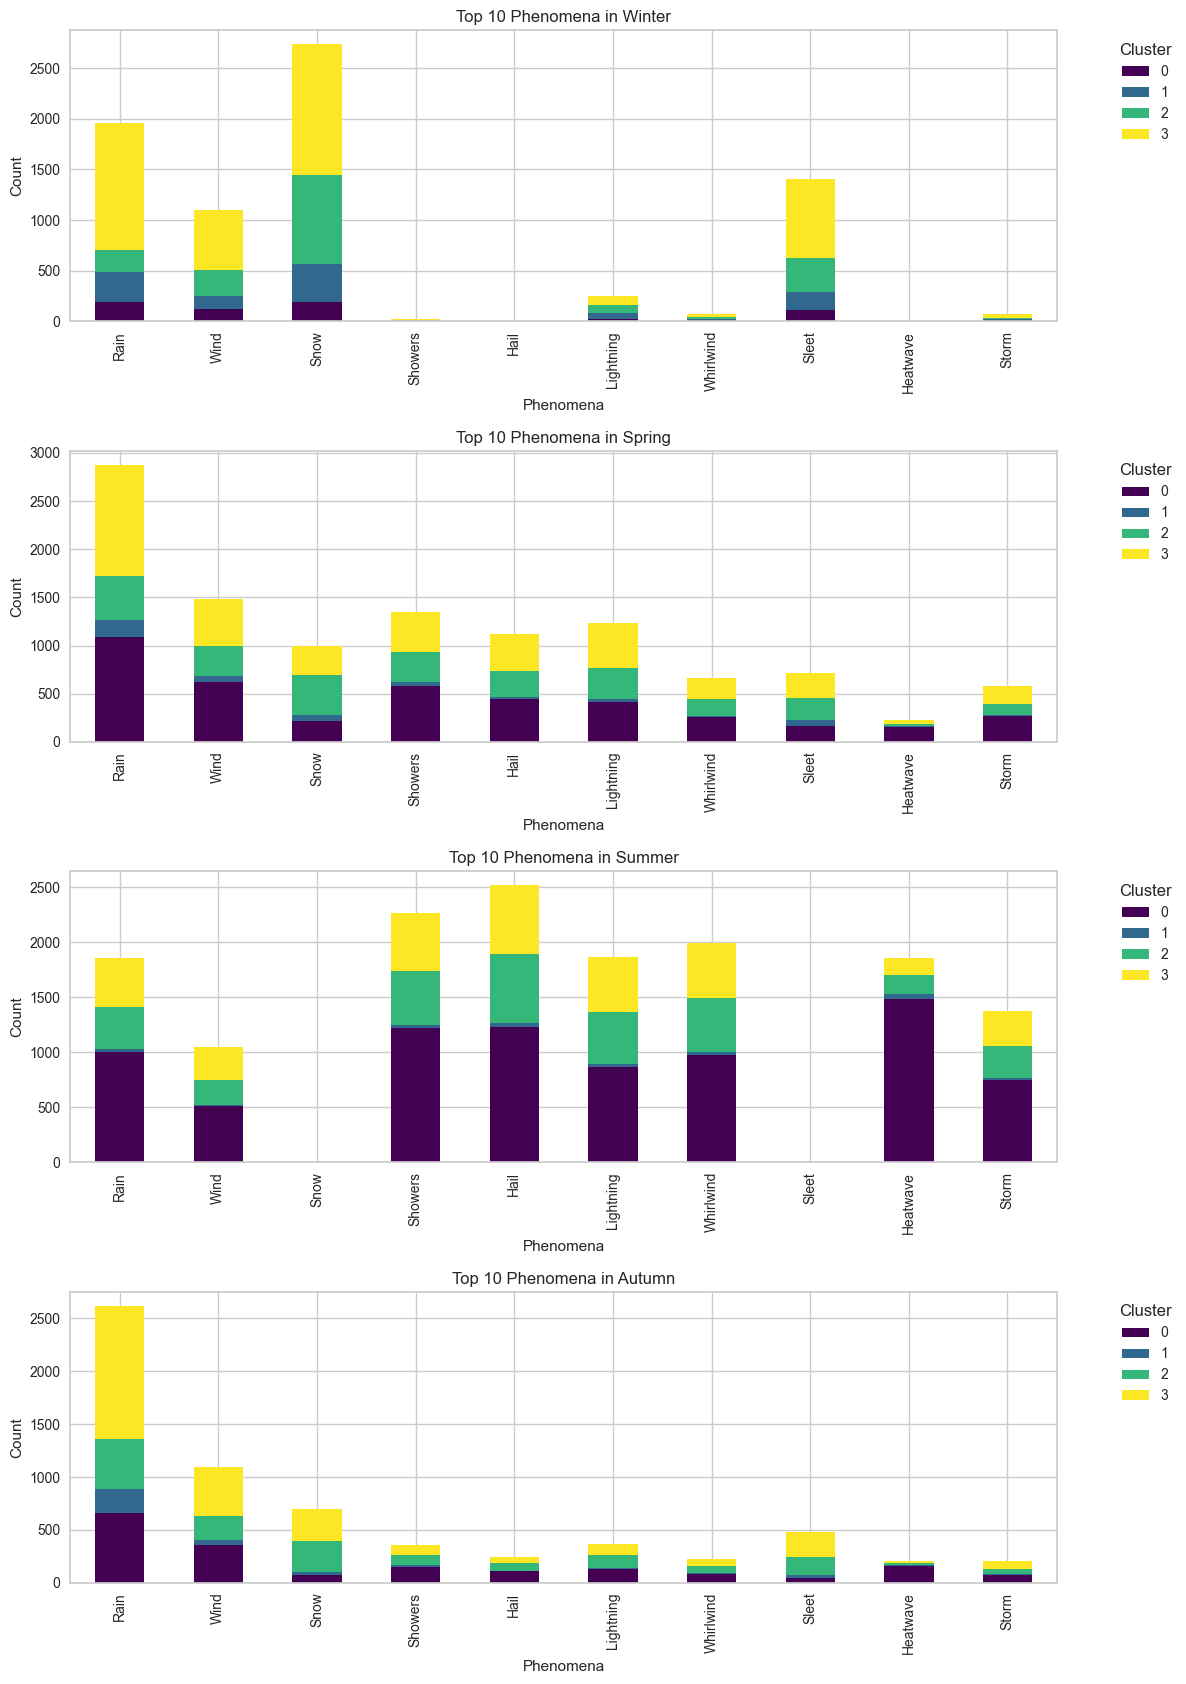

In [418]:
# Identify the top 10 phenomena based on their overall occurrence
top_10_phenomena = phenomena_counts.sum(axis=0).sort_values(ascending=False).head(10).index

# Extract the data for the top 10 phenomena
top_phenomena_data = phenomena_counts[top_10_phenomena]

# Visualizing the top 10 phenomena for each season and cluster
fig, axes = plt.subplots(nrows=4, figsize=(12, 17))

for idx, season in enumerate(seasons):
    ax = axes[idx]
    
    # Extracting data for the current season
    seasonal_data = top_phenomena_data.loc[season]
    
    # Plotting
    seasonal_data.T.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title(f'Top 10 Phenomena in {season}')
    ax.set_ylabel('Count')
    ax.set_xlabel('Phenomena')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Descriptive statistics for every cluster

In [419]:
# Group by cluster and compute descriptive statistics
cluster_descriptive_stats = data_exploded.groupby('Cluster').agg({
    'pm10_quality': ['mean', 'median', 'max', 'min'],
    'air_pressure': ['mean', 'median', 'max', 'min'],
    'temperature': ['mean', 'median', 'max', 'min'],
    'humidity': ['mean', 'median', 'max', 'min']
})
cluster_descriptive_stats

pm10_quality                                 air_pressure  \
                mean     median         max      min         mean   
Cluster                                                             
0          25.877299  24.937500   63.500000   2.1800  1000.398080   
1          58.959509  52.832500  230.285714  35.7425  1000.766356   
2          22.836281  20.853333   88.075000   1.4500   946.322733   
3          21.277777  20.473333   48.855000   2.1000  1006.512984   

                                      temperature                      \
              median      max     min        mean     median      max   
Cluster                                                                 
0        1001.800000  1099.80  964.60   19.407341  21.535000  34.3775   
1        1003.266667  1059.35  930.54    5.152165   4.303333  30.1600   
2         946.450000   976.50  805.70   11.497582  12.220000  34.0350   
3        1005.150000  1100.00  974.30   10.238409   9.562500  38.9325   

                     humidity                           
               min       mean median    max        min  
Cluster                                                 
0       -14.205000  60.343610  62.00   82.0   6.000000  
1       -19.123333  79.490036  80.75  100.0  24.666667  
2       -17.650000  77.498447  78.00  100.0  28.166667  
3       -16.333333  85.601902  85.50  100.0  51.000000